#**Tech Challenge - Ibovespa**

## Descrição

Realizar um modelo preditivo com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base. Demonstrar para o time de investimentos:
1. O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%).

## Análise

**Optamos por utilizar dados dos últimos 5 anos, pois percebemos que ao testar apenas 6 meses ou 1 ano, o comportamento dos dados era mais uniforme e talvez não refletisse variações anuais. Caso usássemos a janela de 2 ou 3 anos, teríamos o comportamento da pandemia como início da base, por isso optamos por uma janela mais longa. É importante também considerar que a variação inflacionária dos últimos anos e as eleições presidenciais podem ter influência nas variações do índice.**  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df_5a = pd.read_csv('Ibovespa5a.csv')
df_5a

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,31.07.2023,121.943,120.188,122.149,120.188,"10,12M","1,46%"
1,28.07.2023,120.187,120.002,120.660,119.706,"8,46M","0,16%"
2,27.07.2023,119.990,122.560,122.599,119.825,"10,68M","-2,10%"
3,26.07.2023,122.560,122.003,122.747,121.370,"9,99M","0,45%"
4,25.07.2023,122.008,121.344,123.010,121.344,"11,43M","0,55%"
...,...,...,...,...,...,...,...
1236,06.08.2018,81.051,81.445,81.765,80.965,"2,59M","-0,47%"
1237,03.08.2018,81.435,79.656,81.792,79.656,"3,92M","2,26%"
1238,02.08.2018,79.637,79.237,79.896,78.573,"3,10M","0,42%"
1239,01.08.2018,79.302,79.213,79.731,78.769,"3,33M","0,10%"


In [3]:
df_5a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241 entries, 0 to 1240
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      1241 non-null   object 
 1   Último    1241 non-null   float64
 2   Abertura  1241 non-null   float64
 3   Máxima    1241 non-null   float64
 4   Mínima    1241 non-null   float64
 5   Vol.      1241 non-null   object 
 6   Var%      1241 non-null   object 
dtypes: float64(4), object(3)
memory usage: 68.0+ KB


In [4]:
print("Quantidade de dados nulos: ", df_5a.isna().sum().sum())

Quantidade de dados nulos:  0


In [5]:
print("Quantidade de linhas e colunas: ", df_5a.shape)

Quantidade de linhas e colunas:  (1241, 7)


In [6]:
#transformar data em formato datetime:
df_5a['Data'] = pd.to_datetime(df_5a.Data, format = "%d.%m.%Y")

In [7]:
#dropar as outras colunas (mantendo somente o índice de fechamento da bolsa, a coluna Último):
df_5a.drop(["Abertura", "Mínima", "Máxima", "Vol.", "Var%"], inplace=True, axis=1)

In [8]:
df_5a

,Data,Último
0,2023-07-31,121.943
1,2023-07-28,120.187
2,2023-07-27,119.990
3,2023-07-26,122.560
4,2023-07-25,122.008
...,...,...
1236,2018-08-06,81.051
1237,2018-08-03,81.435
1238,2018-08-02,79.637
1239,2018-08-01,79.302


In [9]:
df_5a_1 = df_5a.set_index('Data')

In [10]:
df_5a_1

,Último
Data,
2023-07-31,121.943
2023-07-28,120.187
2023-07-27,119.990
2023-07-26,122.560
2023-07-25,122.008
...,...
2018-08-06,81.051
2018-08-03,81.435
2018-08-02,79.637


In [11]:
#função pra plotar gráficos mantendo a mesma configuração:

def plotar(titulo, labelx, labely, x, y, dataset):
  sns.set_style("darkgrid")
  ax = sns.lineplot(x=x, y=y, data=dataset)
  ax.figure.set_size_inches(15, 5)
  ax.set_title(titulo, loc="left", fontsize=16)
  ax.set_xlabel(labelx, fontsize=12)
  ax.set_ylabel(labely, fontsize=12)
  ax = ax

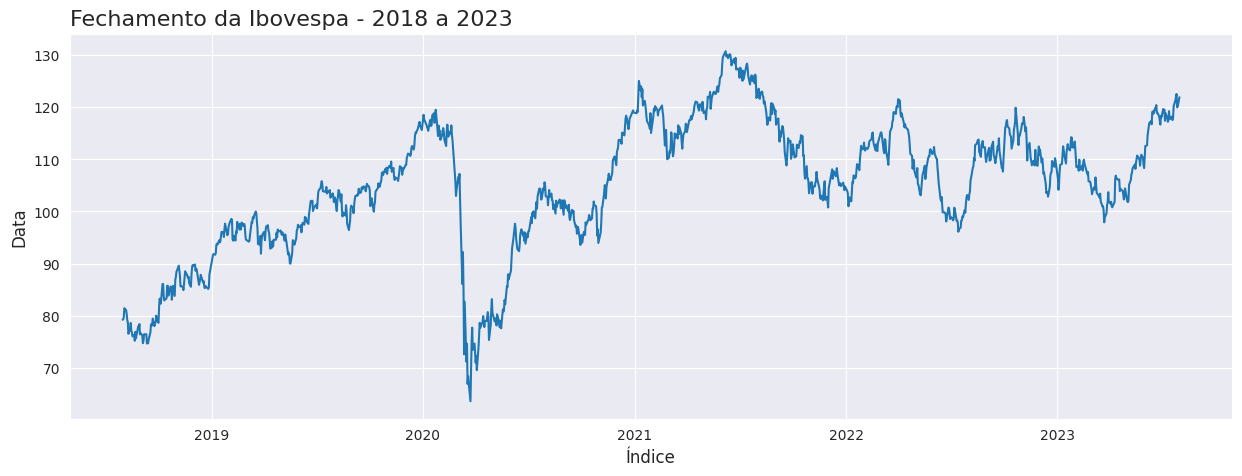

In [12]:
#plotar a série:

plotar("Fechamento da Ibovespa - 2018 a 2023", "Índice", "Data", "Data", "Último", df_5a_1)

In [13]:
#decompor a série nos seus componentes - tendência, sazonalidade, resíduo
resultados = seasonal_decompose(df_5a_1["Último"], period=6)

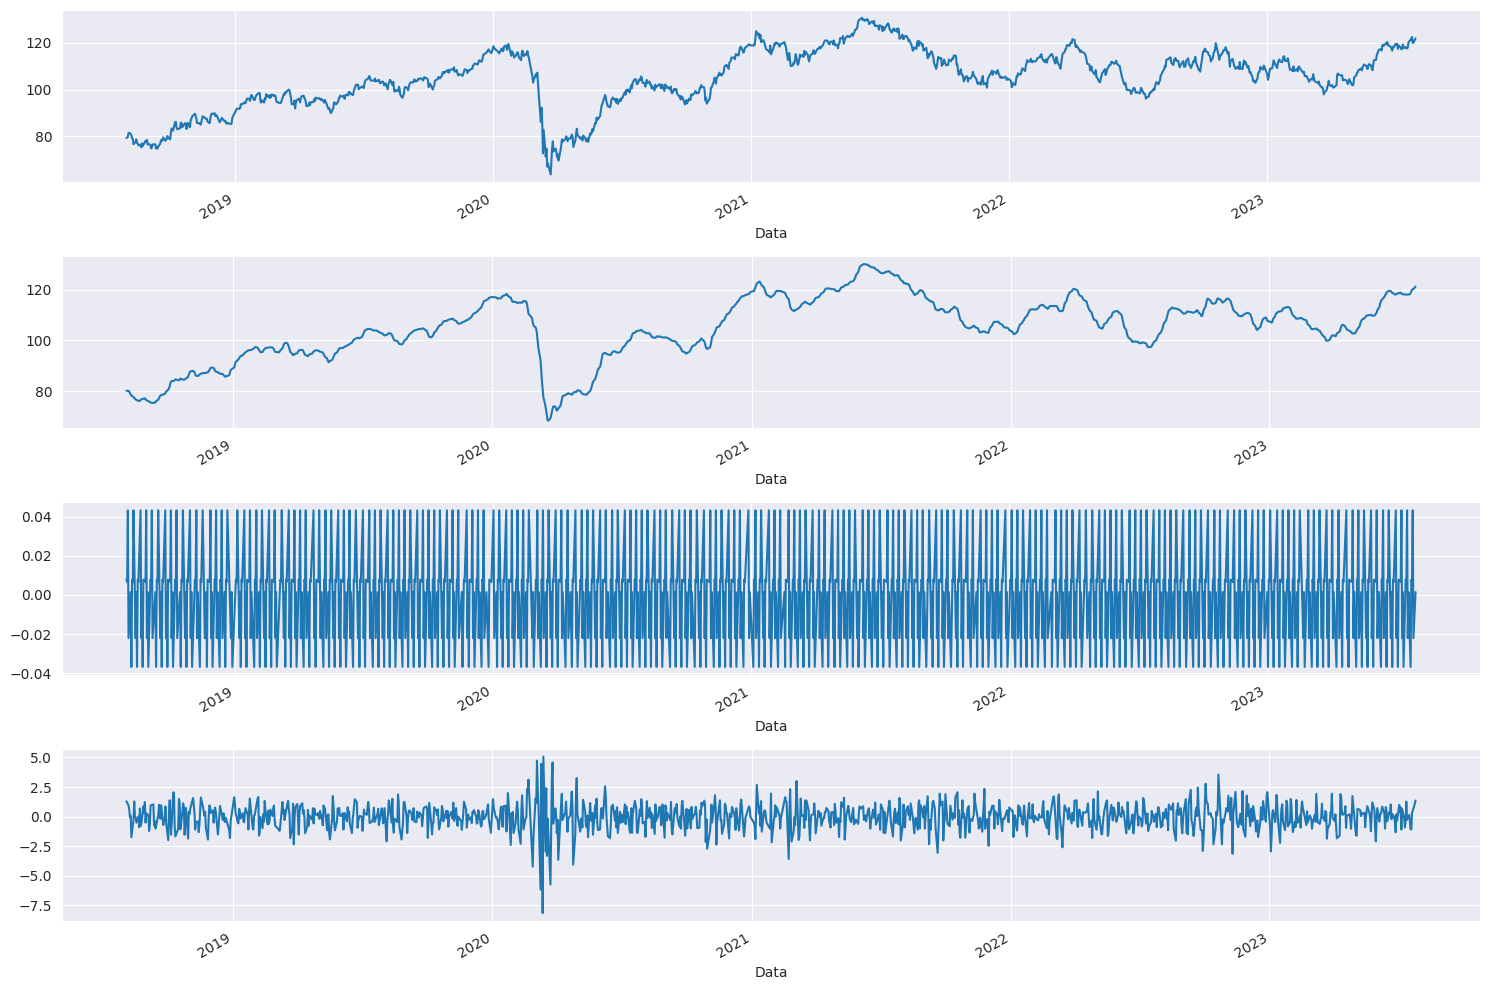

In [14]:
#plotar os componentes da série - tendência, sazonalidade, resíduo

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

**A tendência é levemente crescente, mas houve grande queda em 2020, provavelmente devido à pandemia do COVID-19. O ano de 2022 parece um pouco mais instável que o restante, talvez pelas eleições presidenciais e/ou guerra na Ucrânia. Há padrão claro de sazonalidade e ruído.**

## Teste ADF

Usaremos o **Teste ADF (Augmented Dickey-Fuller)** para avaliar se a série é estacionária ou não.

*   H0: hipótese nula (série não estacionária)
*   H1: hipótese alternativa (série estacionária - rejeição da hipótese nula)

Para rejeitar H0 e considerar H1, o p-value precisa ser menor ou igual q algum nível de significância (q definimos de acordo com a necessidade - O mais comum é 5%).

Quanto menor o p-value, mais evidências contra a hipótese nula se tem. Ou seja, se p-value é 0.05 (5%), rejeitamos H0 com nível de confiança de 95%. Se p-value maior que isso, não rejeitamos H0.

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
#transforma os valores do df em um array:

x = df_5a_1.Último.values

In [17]:
#cálculo do ADF:

result = adfuller(x)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-value: {result[1]}")
print("Valores críticos: ")

#fazer for pra mostrar valores críticos com 1%, 5% e 10% de intervalo de confiança:
for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.156928898112617
P-value: 0.2222473074886563
Valores críticos: 
	1%: -3.4356689751083374
	5%: -2.8638888336592387
	10%: -2.5680205519744055


**análise**: p valor alto (0.22) e valor do teste estatístico (-2.15) foi maior que os valores críticos. **Nesse caso, a série não é estacionária.**

## Transformação da série em estacionária

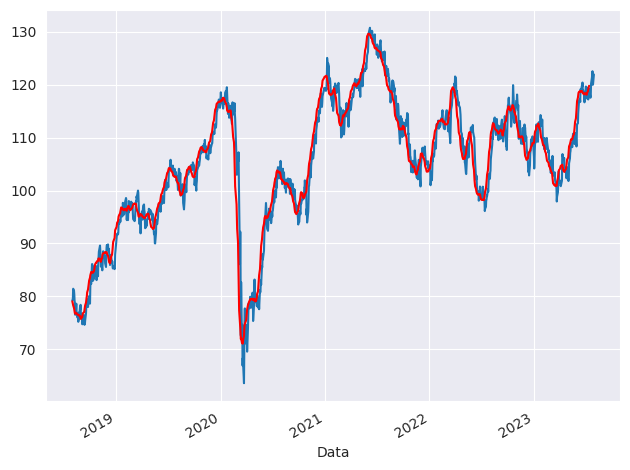

In [18]:
#cria média móvel
ma = df_5a_1.rolling(12).mean()

f, ax = plt.subplots()
df_5a_1.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

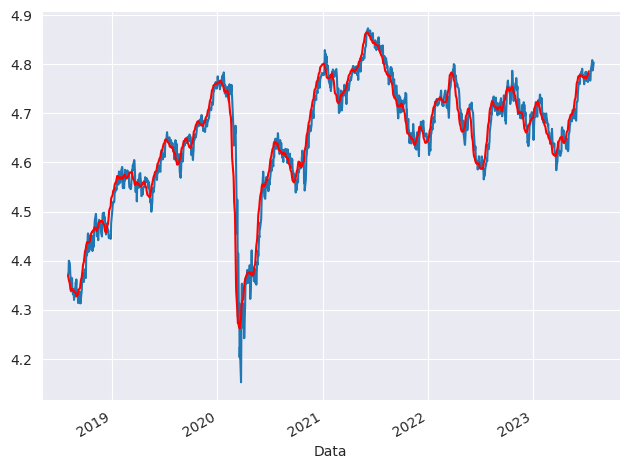

In [19]:
df_log = np.log(df_5a_1)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

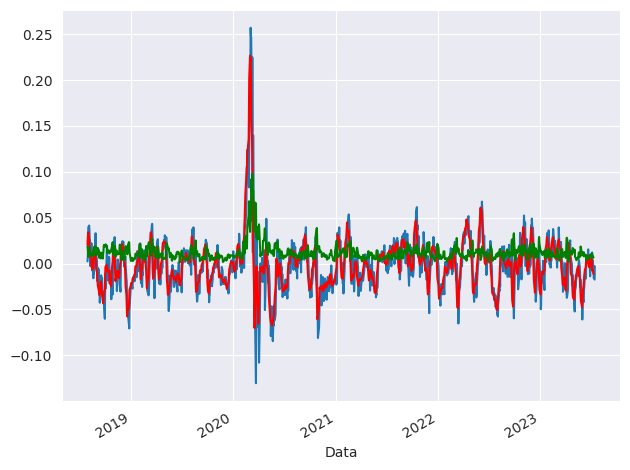

In [20]:
#subtrair a média móvel:

df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(5).mean()

std = df_s.rolling(5).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

In [21]:
X_s = df_s.Último.values

result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-value: {result_s[1]}")
print("Valores críticos: ")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -8.674445599609713
P-value: 4.455326421606348e-14
Valores críticos: 
	1%: -3.435712593855191
	5%: -2.863908078253003
	10%: -2.5680308008925294


Resultado: p-value mto próximo de zero (logo, abaixo dos 5%) e teste estatístico menor que os valores críticos (-8.67). **Essa é uma série estacionária agora.**



Teste ADF
Teste Estatístico: -10.712169847486882
P-value: 3.3104437782869518e-19
Valores críticos: 
	1%: -3.4357884107845953
	5%: -2.863941528023427
	10%: -2.56804861503762


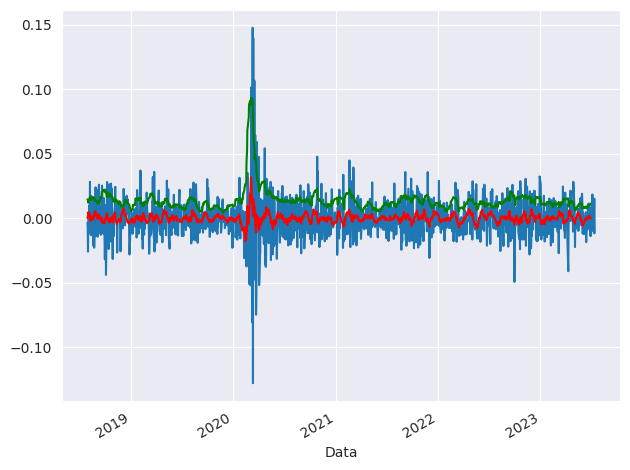

In [22]:
#usando a diferenciação (derivada) pra transformar a série em mais estacionária:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()


X_diff = df_diff.Último.dropna().values

result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-value: {result_diff[1]}")
print("Valores críticos: ")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

**Ao usar a diferenciação para transformar a série em cada vez mais estacionária, o P value fica ainda menor (tendendo a zero) e como se a linha vermelha do gráfico (média) fica cada vez mais "esticada", quase reta. Utilizaremos a série após essa última diferenciação para construir o modelo.**

## ACF e PACF

**Autocorrelação (ACF)**: mostra como os pontos dados em diferentes pontos no tempo estão linearmente relacionados entre si. O número de
intervalos entre duas medições é conhecido como lag. O gráfico mostra a correlação entre a série e seus valores passados em incrementos de tempo
cada vez maiores.

**Autocorrelação parcial (PACF)**: é a correlação parcial desta série temporal com ela mesma em determinado lag, dadas as informações entre os dois tempos.

In [23]:
from statsmodels.tsa.stattools import acf, pacf

In [24]:
#nlags: escolhemos previsão para 20 dias. Como a série só tem dias úteis, 20 dias corresponde a aproximadamente 1 mês.
lag_acf = acf(df_diff.dropna(), nlags=80)
lag_pacf = pacf(df_diff.dropna(), nlags=80)

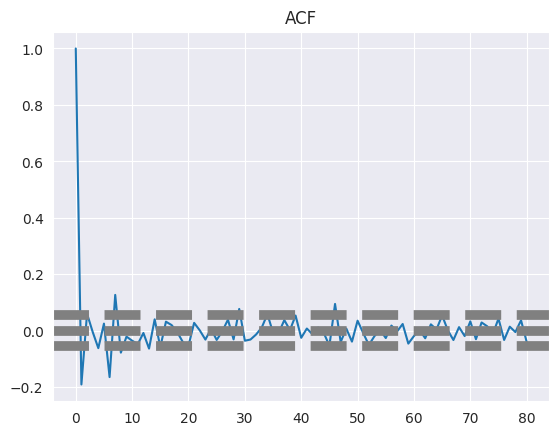

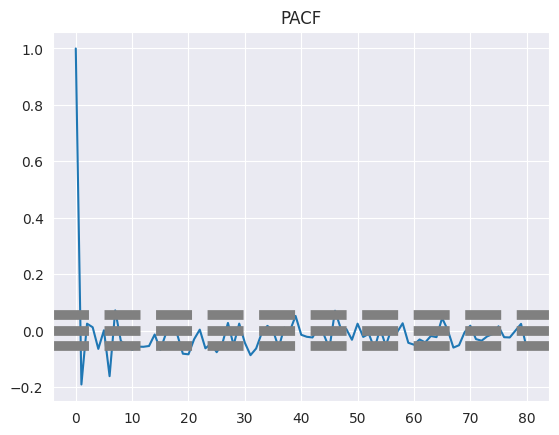

In [25]:
#limite crítico 5% da ACF:
#1.96/sqrt(N-d) -> N é núm de pontos do df e d é num de vezes q nós diferenciamos o df (diff). Obs: esse 1.96 é aquele intervalo interquartil da estatística

plt.plot(lag_acf)

plt.axhline(y=-1.96/(np.sqrt((len(df_diff) - 1))), linestyle="--", color="gray", linewidth=7)
plt.axhline(y=0, linestyle="--", color="gray", linewidth=7)
plt.axhline(y=1.96/(np.sqrt((len(df_diff) - 1))), linestyle="--", color="gray", linewidth=7)
plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y=-1.96/(np.sqrt((len(df_diff) - 1))), linestyle="--", color="gray", linewidth=7)
plt.axhline(y=0/(np.sqrt((len(df_diff) - 1))), linestyle="--", color="gray", linewidth=7)
plt.axhline(y=1.96/(np.sqrt((len(df_diff) - 1))), linestyle="--", color="gray", linewidth=7)
plt.title("PACF")
plt.show()


**Outra forma de representar a ACF e PACF:**

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

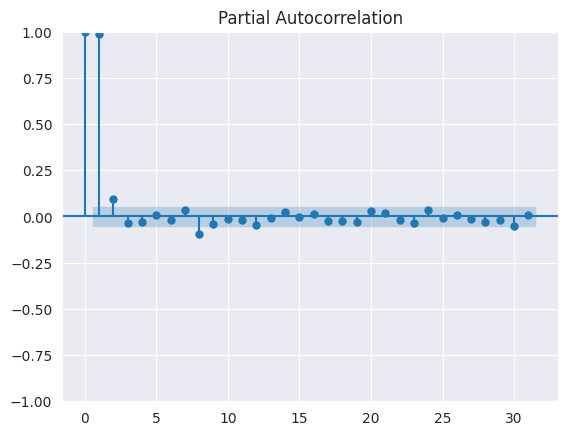

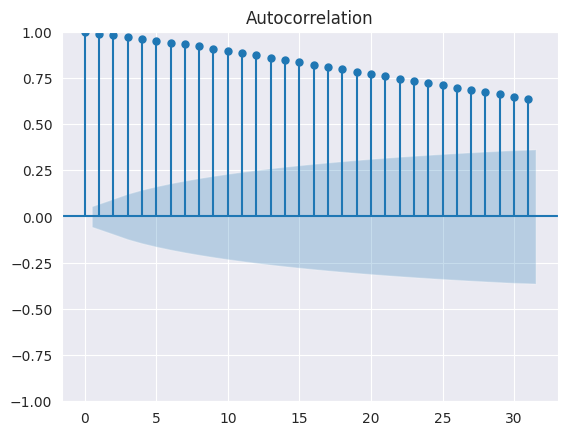

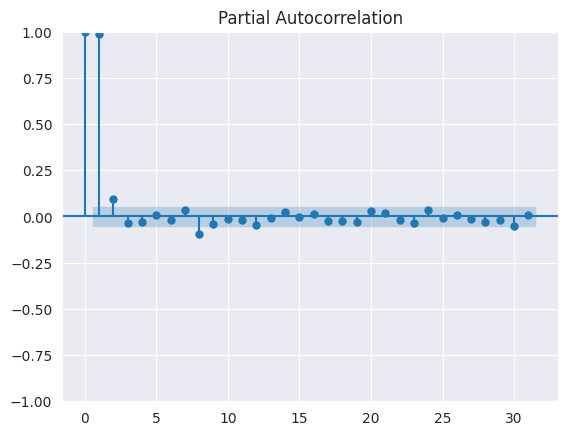

In [27]:
plot_acf(df_5a_1.Último)
plot_pacf(df_5a_1.Último)

**Na ACF, temos uma correlação maior com lags mais recentes, que se perdem com o tempo.**


## Modelando e realizando o forecasting

###**Modelagem**

In [28]:
#renomear colunas com nomes adequados pra usar nas bibliotecas (data = ds, coluna target = y)
df_5a = df_5a.rename(columns={'Data':'ds','Último':'y'})

In [29]:
df_5a

,ds,y
0,2023-07-31,121.943
1,2023-07-28,120.187
2,2023-07-27,119.990
3,2023-07-26,122.560
4,2023-07-25,122.008
...,...,...
1236,2018-08-06,81.051
1237,2018-08-03,81.435
1238,2018-08-02,79.637
1239,2018-08-01,79.302


In [104]:
#df_5a["unique_id"] = df_5a["ds"].dt.year

In [119]:
#df_5a["unique_id"] = df_5a["ds"].dt.day_name()

In [32]:
#df_5a['unique_id'] = df_5a['ds'].dt.to_period('M')

In [33]:
#df_5a['unique_id'] = pd.to_datetime(df_5a['ds']).dt.strftime('%Y_%m')

In [167]:
df_5a["unique_id"] = 'Ações'

In [169]:
df_5a

,ds,y,unique_id
0,2023-07-31,121.943,Ações
1,2023-07-28,120.187,Ações
2,2023-07-27,119.990,Ações
3,2023-07-26,122.560,Ações
4,2023-07-25,122.008,Ações
...,...,...,...
1236,2018-08-06,81.051,Ações
1237,2018-08-03,81.435,Ações
1238,2018-08-02,79.637,Ações
1239,2018-08-01,79.302,Ações


In [170]:
df_5a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241 entries, 0 to 1240
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         1241 non-null   datetime64[ns]
 1   y          1241 non-null   float64       
 2   unique_id  1241 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 29.2+ KB


In [217]:
#separando a base: usamos esse ano para teste e o restante para treino:

treino = df_5a.loc[(df_5a['ds'] < '2023-04-01') & (df_5a['ds'] > '2023-01-01')]
valid = df_5a.loc[df_5a["ds"] >= '2023-04-01']

In [218]:
treino.head(70)

,ds,y,unique_id
82,2023-03-31,101.882,Ações
83,2023-03-30,103.713,Ações
84,2023-03-29,101.793,Ações
85,2023-03-28,101.185,Ações
86,2023-03-27,99.670,Ações
...,...,...,...
140,2023-01-06,108.964,Ações
141,2023-01-05,107.641,Ações
142,2023-01-04,105.334,Ações
143,2023-01-03,104.166,Ações


In [219]:
valid.tail(25)

,ds,y,unique_id
57,2023-05-10,107.448,Ações
58,2023-05-09,107.114,Ações
59,2023-05-08,106.042,Ações
60,2023-05-05,105.148,Ações
61,2023-05-04,102.174,Ações
62,2023-05-03,101.797,Ações
63,2023-05-02,101.927,Ações
64,2023-04-28,104.432,Ações
65,2023-04-27,102.923,Ações
66,2023-04-26,102.312,Ações


In [220]:
h = valid["ds"].nunique()
#variável h = horizonte, pra quanto tempo pra frente eu quero prever. Validação curta: qto maior o tempo de previsão, maior o erro (banda de previsão parece cone invertido).
#ao fazer essa fórmula pro h, vai pegar o mesmo período que usei pra validar o modelo (no caso, 3 meses)


In [221]:
h

82

In [222]:
#função para calcular o WMAPE:

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [223]:
!pip install statsforecast

In [224]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

###**Modelo 1:**

**Usar modelo baseline (Naive) para prever os dados de aproximadamente 4 meses de 2023 (82 dias úteis - abr, mai, jun, jul), com base de treino de 5 anos.**

WMAPE: 6.48%


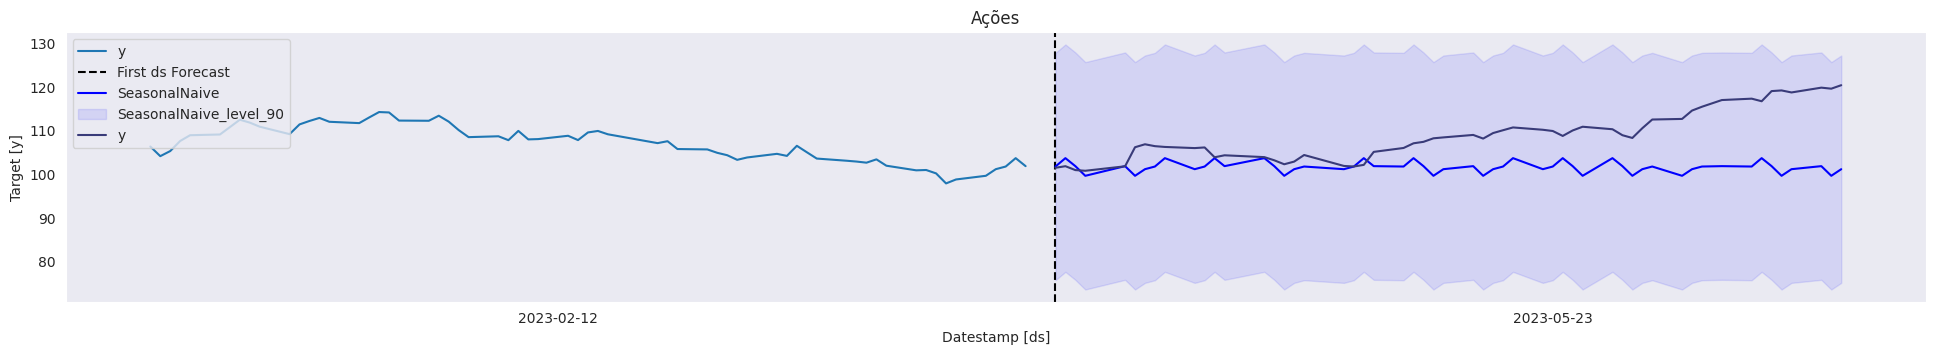

In [225]:
#solução usando o último dia do período de treino pra prever o período de teste
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)  #criar a classe model. Usar models como "naive" (modelo escolhido), frequência de medição (diária), n_jobs=número de CPUs/núcleos do processador usadas (-1 significa usar todas as CPUs)
model.fit(treino)

forecast_df = model.predict(h=h, level=[90])  #predição: variável h (horizonte), level: nível de predição (nesse caso 90%)
forecast_df = forecast_df.merge(valid, on=['ds', 'unique_id'], how='left') #fazer merge da tabela de dados preditos com dados de validação. Equivalente ao left join (queremos ver o modelo com base na tabela da esquerda e o que é comum com a tabela da direita)
forecast_df = forecast_df.dropna()

wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values) #pegar os valores da coluna y (verdadeiro) e os valores do Naive (predito)
print(f"WMAPE: {wmape1:.2%}")

model.plot(treino, forecast_dfs, level=[90], unique_ids=["Ações"],engine ='matplotlib', max_insample_length=200)

**O wmape mostra valor de erro baixo: 6.48%, porém, o modelo Naive ignora a sazonalidade dos dados e prevê o mesmo valor para toda a categoria '2023'. No início do cone há alguns acertos, mas como a tendência do período está crescente, a previsão é que a porcentagem de erro aumente com o passar do tempo, se a série continuar apresentando esse comportamento.**


###**Modelo 2:**

**Usar modelo baseline com sazonalidade (SeasonalNaive) para prever os dados de aproximadamente 4 meses de 2023 (82 dias úteis - abr, mai, jun, jul), com base de treino de 5 anos.**

WMAPE: 6.76%


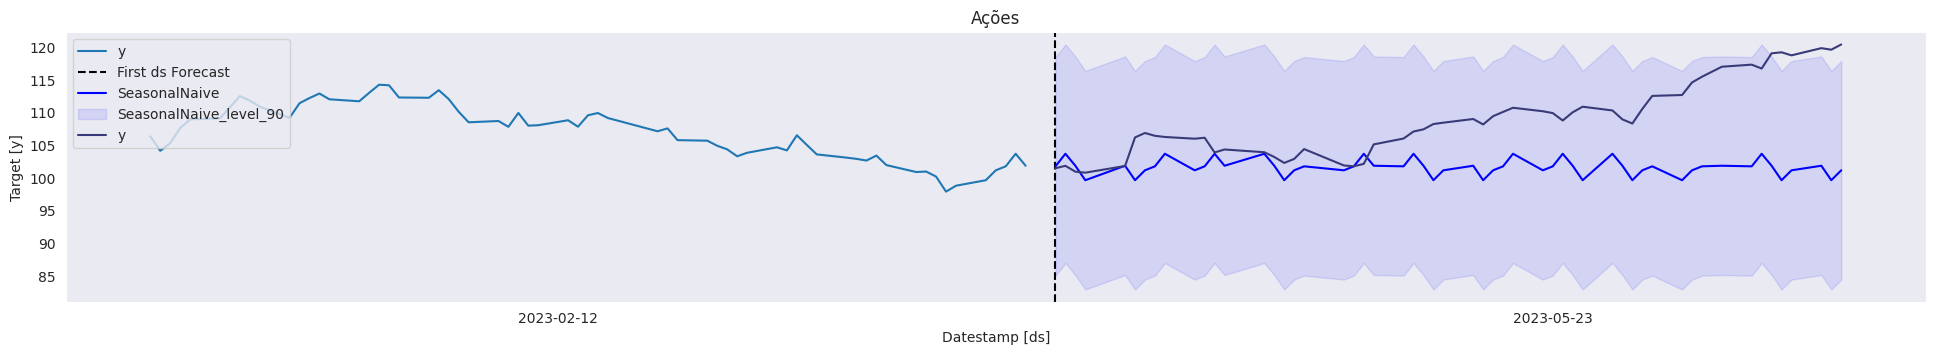

In [226]:
#trabalhar com modelo de baseline (ainda baseado nos últimos valores de treino), porém considerando a sazonalidade
#pra isso, usamos o modelo SeasonalNaive, usando os dados de 1 semana pra prever
model_s = StatsForecast(models=[SeasonalNaive(season_length=5)], freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=h, level=[90])
forecast_dfs = forecast_dfs.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfs = forecast_dfs.dropna()

wmape2 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f"WMAPE: {wmape2:.2%}")

model_s.plot(treino, forecast_dfs, level=[90], unique_ids=["Ações"],engine ='matplotlib', max_insample_length=100)

**O wmape aumentou um pouco em relação ao Naive: 6.76%. Mesmo considerando a sazonalidade dos dados, o modelo não inclui a tendência crescente da série, logo, a porcentagem de erro pode aumentar com o passar do tempo, se a série continuar apresentando essa tendência.**

###**Modelo 3:**

**Usar modelo baseline com sazonalidade e média móvel (SeasonalWindowAverage) para prever os dados de aproximadamente 4 meses de 2023 (82 dias úteis - abr, mai, jun, jul), com base de treino de 5 anos.**

WMAPE: 5.96%


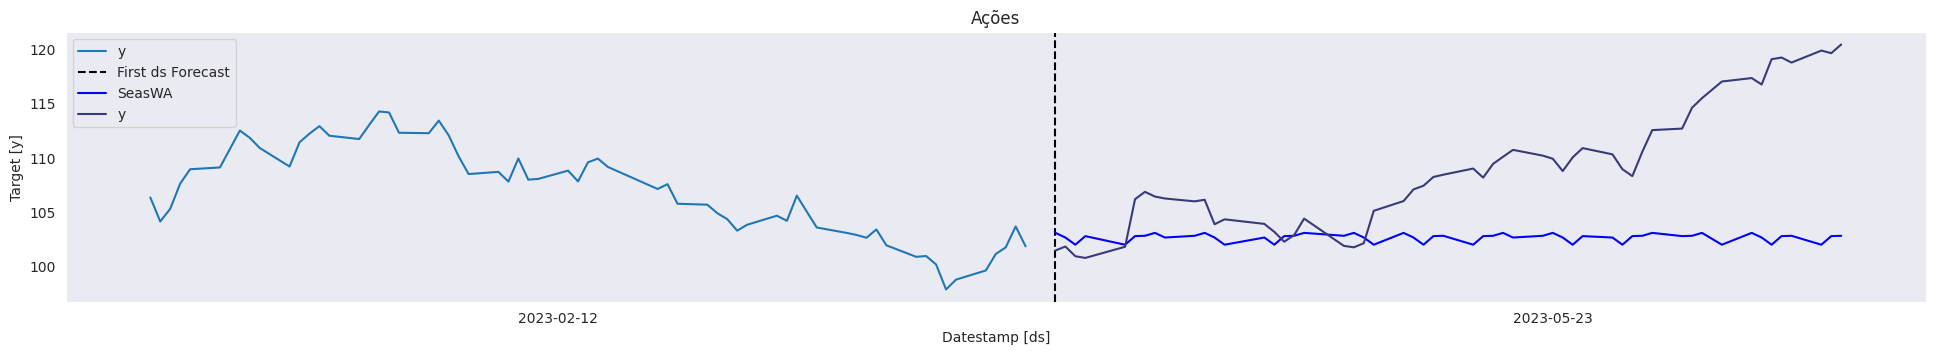

In [227]:
#trabalhar com modelo de baseline (ainda baseado nos últimos valores de treino), considerando a sazonalidade e a média móvel (window_size)
#pra isso, usamos o modelo SeasonalWindowAverage, usando os dados de 1 semana pra prever e média das últimas 5 semanas
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=5, window_size=5)], freq='D', n_jobs=-1)
model_sm.fit(treino)

forecast_dfsm = model_sm.predict(h=h)
forecast_dfsm = forecast_dfsm.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfsm = forecast_dfsm.dropna()

wmape3 = wmape(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
print(f"WMAPE: {wmape3:.2%}")

model_sm.plot(treino, forecast_dfsm, level=[90], unique_ids=["Ações"],engine ='matplotlib', max_insample_length=300)

In [228]:
forecast_dfsm

,unique_id,ds,SeasWA,y
2,Ações,2023-04-03,103.122795,101.506
3,Ações,2023-04-04,102.694199,101.869
4,Ações,2023-04-05,102.035400,100.978
5,Ações,2023-04-06,102.824997,100.822
9,Ações,2023-04-10,102.035400,101.847
10,Ações,2023-04-11,102.824997,106.214
11,Ações,2023-04-12,102.854996,106.890
12,Ações,2023-04-13,103.122795,106.458
13,Ações,2023-04-14,102.694199,106.279
16,Ações,2023-04-17,102.854996,106.016


**O wmape dimimuiu em relação aos outros modelos: 5.96%. Mesmo considerando a sazonalidade e a média móvel dos dados, o modelo não inclui a tendência crescente da série, logo, a porcentagem de erro pode aumentar com o passar do tempo, se a série continuar apresentando essa tendência.**

###**Modelo 4:**

**Usar modelo ARIMA para prever os dados de aproximadamente 4 meses de 2023 (82 dias úteis - abr, mai, jun, jul), com base de treino de 5 anos.**

WMAPE: 6.48%


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


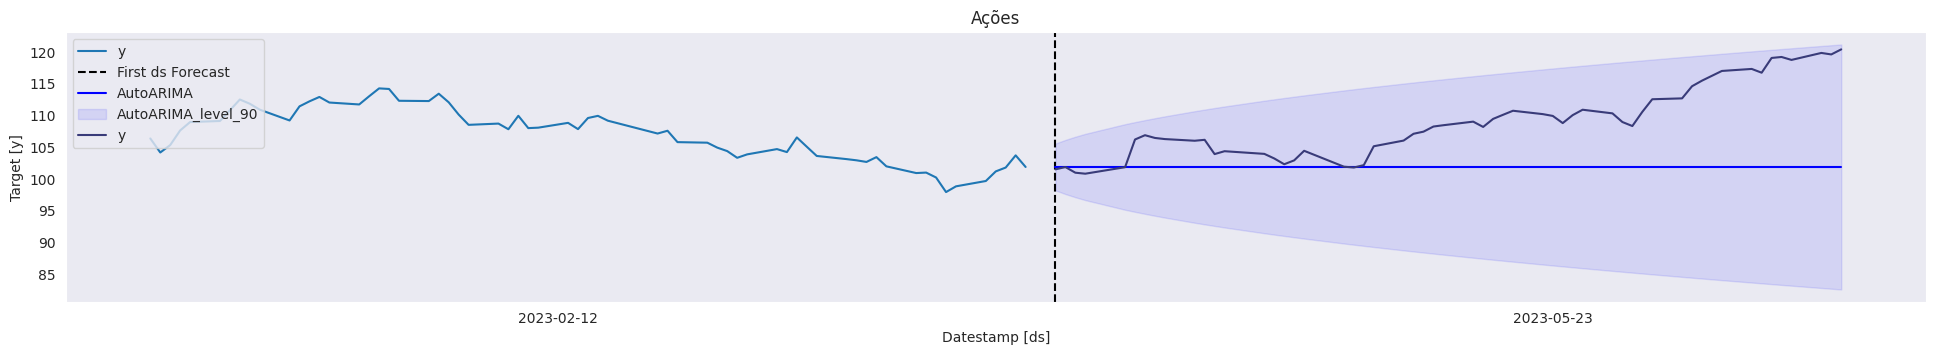

In [229]:
#AR: Modelo autoregressivo (olha para os dados do passado e acha uma correlação futura)
#I: Integrado (quantidade que a série foi diferenciada) - ele tenta transformar a série estacionária em não estacionária (como fizemos na outra aula), e faz uma quantidade de diffs pra isso. Esse I é a qtde de diffs.
#MA: Média Móvel
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(treino)

forecast_dfa = model_a.predict(h=h, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfa = forecast_dfa.dropna()

wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")

model_a.plot(treino, forecast_dfa, level=[90], engine ='matplotlib', max_insample_length=200)

In [230]:
forecast_dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 2 to 81
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   unique_id        54 non-null     object        
 1   ds               54 non-null     datetime64[ns]
 2   AutoARIMA        54 non-null     float32       
 3   AutoARIMA-lo-90  54 non-null     float32       
 4   AutoARIMA-hi-90  54 non-null     float32       
 5   y                54 non-null     float64       
dtypes: datetime64[ns](1), float32(3), float64(1), object(1)
memory usage: 2.3+ KB


**INTERPRETAR ARIMA**

links:
https://mariofilho.com/como-prever-series-temporais-univariadas-usando-python/

https://forecastegy.com/posts/multiple-time-series-forecasting-with-holt-winters-in-python/

https://nixtla.github.io/statsforecast/docs/how-to-guides/automatic_forecasting.html


https://quantbrasil.com.br/descobrindo-as-tendencias-do-ibovespa-utilizando-o-expoente-de-hurst/


https://osf.io/preprints/socarxiv/8qgyu/

https://www.linkedin.com/pulse/prevendo-o-%C3%ADndice-bovespa-utilizando-modelos-de-s%C3%A9rie-felipe-sembay/?originalSubdomain=pt

Não importa qual o método utilziado, percebe-se que a curva de previsão segue mais ou menos o mesmo padrão em todos.

Dentro os modelos, o menor erro ocorreu coma utilização do SeasonalWindowAverage. Contudo a diferença dos erros entre os modelos é muito pequena, onde a maior foi entre o SeasonalWindowAverage e o SeasonaNaive com apenas 0,24 pontos percentuais. Como a SeasonalWindowAverage não traz uma área de confiabilidade, e a diferença entre os modelos ser muito pequena, o modelo SeasonaNaive pode ser a melhor opção, por utilizar menos recursos computacionais do que ARIMA.